In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib.pyplot import pie, axis, show
import seaborn as sns
import missingno as msno
from scipy import stats
import matplotlib.pyplot as plt
import yaml

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import RFE, SelectKBest, f_regression, mutual_info_regression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import statsmodels.regression.linear_model as sm
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, CompoundKernel
import sklearn_relief as sr
from skrebate import ReliefF
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
import lightgbm as ltb
from sklearn.svm import SVR
from scipy.stats import ks_2samp
from tabulate import tabulate

from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import BorderlineSMOTE

from sklearn.multioutput import RegressorChain, MultiOutputRegressor

from helper import preprocess, get_test_train_data, get_features_kbest, get_features_ref, get_features_ref_multiout,\
    get_features_relieff, get_model_name, cross_val, get_scores, outlier_detect, train_models,\
    find_lowest_respponse_value, find_highest_respponse_value, find_closest_to_42, check_aggreement,\
    get_concordant_discordant, print_change_mean, get_perc, percentage_change_original_data, calculate_percentage_change,\
    calculate_percentage_change_othre_responses, calculate_count_diff, calculate_change_diff, check_distribution,\
    drug_class_visualization, drug_class_outlier_remove, plot_scatter_with_CI, plot_scatter, countUsers

import torch
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(42)

%matplotlib inline


In [2]:
df_X_train = pd.read_csv('resources/data/imputed_all_training_data_wo_ldl.csv', sep = ',',decimal = '.', encoding = 'utf-8', engine ='python',index_col=0)
df_X_test = pd.read_csv('resources/data/testing_all_data_wo_ldl.csv', sep = ',',decimal = '.', encoding = 'utf-8', engine ='python',index_col=0)
is_train_with_all=False 

In [3]:
# Read common variables from a YAML file
with open('common_variables.yaml', 'r') as file:
    common_data = yaml.safe_load(file)


In [4]:


response_variable_list = common_data['response_variable_list']

correlated_variables = common_data['correlated_variables']

variables = df_X_train.columns
thresh = common_data['thresh']
keep = []
rem = []


In [5]:
X_train_ = preprocess(df_X_train, response_variable_list)

Shape of data after excluding missing response: (1566, 125)
Shape of full data after selecting date range dates > 21 days (1084, 115)


In [6]:
X_test_ = preprocess(df_X_test, response_variable_list)

Shape of data after excluding missing response: (156, 125)
Shape of full data after selecting date range dates > 21 days (102, 115)


In [7]:
df, X_train, X_test, Y_train, Y_test, X, Y, scaler, X_test_before_scale = get_test_train_data(X_train_, X_test_, response_variable_list)

X_train shape:  (1077, 107)
(1077, 107)
{3.0, 4.0}
[(3.0, 440), (4.0, 637)]
[(3.0, 637), (4.0, 637)]


In [8]:
df.corr().abs().unstack().sort_values(ascending = False).drop_duplicates().head(10)


init_year        init_year        1.000000
bmi_12m          bmi              0.953047
chd              cvd_comp         0.951563
hdl_12m          hdl              0.838497
MD_RCT_mmol_mol  metformin        0.807462
bmi              obese            0.722759
cvd_comp         comb_comp_enn    0.713292
Depression       dg404            0.691750
Mental_dis       dg403            0.680791
hba1c_bl_6m      hba1c_bl_18m     0.677152
dtype: float64

In [9]:
# # train with whole dataset and test with drug class 2,3 and 4 data
if(is_train_with_all):
    combined_df = pd.concat([X_test, Y_test], axis=1)
    testdf = combined_df[(combined_df['drug_class'] == 0.25) | 
                         (combined_df['drug_class'] == 0.375) ]
    X_test = testdf.drop([response_variable], axis = 1)
    Y_test = testdf[response_variable]
    
X_test_original = X_test.copy()

In [10]:
""""
Use drug_class

2=GLP-1 analogues (A10BJ)
3=DPP-4 inhibitors (A10BH)
4=SGLT2 inhibitors (A10BK)
"""

if(is_train_with_all):
    sglt_val = 0.375
    dpp_val = 0.25
else:
    sglt_val = 1
    dpp_val = 0


X_test_ = pd.DataFrame(X_test)
X_train_ = pd.DataFrame(X_train)

X_train = X_train.drop(['init_year'], axis = 1)
X_test = X_test.drop(['init_year'], axis = 1)

print('==== sample count in preprocessed data =======')
print(' number of dpp4 : ', countUsers(3, df))
print(' number of sglt2 : ', countUsers(4, df))

print('==== sample count in training data =======')
print(' number of dpp4 : ', countUsers(dpp_val, X_train_))
print(' number of sglt2 : ', countUsers(sglt_val, X_train_))

print('==== sample count in testing data =======')
print(' number of dpp4 : ', countUsers(dpp_val, X_test_))
print(' number of sglt2 : ', countUsers(sglt_val, X_test_))

==== sample count in preprocessed data =======
 number of dpp4 :  489
 number of sglt2 :  689
==== sample count in training data =======
 number of dpp4 :  637
 number of sglt2 :  637
==== sample count in testing data =======
 number of dpp4 :  49
 number of sglt2 :  52


In [11]:
# TODO FROM HERE

# feature selection
items = [
#     'sp',
#     'smoking',
    'drug_class']
k = 10 # Select top 25 features
    
random.seed(42)

#selected_features = get_features_relieff(X_train, Y_train)
meth = 'multi'
selected_features = np.array([])

if meth == 'multi':
    selected_features = get_features_ref(X_train, Y_train, 30)
    
    
    
elif meth=='single':
    selected_feats=[]
    
    for i in range(Y_train.shape[1]):  # Assuming Y.shape[1] is the number of target features
        #feats = get_features_ref_single(X_train, Y_train.iloc[:, i],12)
        #feats = get_features_relieff(X_train, Y_train.iloc[:, i],10)
        feats = get_features_kbest(X_train, Y_train.iloc[:, i],8)#4

        #feats = ['bmi', 'cvd_comp', 'eGFR', 'hba1c_bl_18m', 'hba1c_bl_6m', 'hdl', 'insulin','ldl', 'obese', 'sum_diab_drugs', 't2d_dur_y', 'trigly', 'drug_class']
        print(feats)
        selected_feats.append(feats)
        
    selected_feats = sum(selected_feats, [])
    # remove duplicate
    selected_feats = np.unique(selected_feats)
    print(meth)
    
    selected_features = np.array(selected_feats)

    
for item in items:
    if item not in selected_features:
        selected_features = np.append(selected_features, item)
        
 #selected_features = ['bmi', 'chd', 'comb_comp_enn', 'drug_class', 'eGFR', 'gluk', 'hba1c_bl_18m',
 #'hba1c_bl_6m', 'hdl', 'ika', 'insulin', 'ldl', 'n_of_dis', 'obese', 'sp',
 #'sum_diab_drugs', 't2d_dur_y', 'trigly']

X_train = X_train[selected_features]
X_test = X_test[selected_features]
number_of_features = len(selected_features)
print(selected_features)


['MD_RCT_mmol_mol', 'hba1c_bl_18m', 'hba1c_bl_6m', 'sp', 'ika', 't2d_dur_y', 'P_Krea', 'eGFR', 'ldl', 'bmi', 'hdl', 'trigly', 'gluk', 'smoking', 'met_oad0', 'pelkka_ins0', 'dpp4', 'insulin', 'sum_diab_drugs', 'hyperten', 'T2D_nocomp', 'concordant_dis', 'comb_comp_enn', 'renal_insuf', 'thyroid', 'C02A', 'C10A', 'dg601', 'n_of_dis', 'drug_class']


In [12]:
################# OUTLIER CODE ################
print('Shape of training data before removing outliers:', np.shape(X_train))
print('Shape of test data before removing outliers:', np.shape(X_test))
    
out_train, out_test = outlier_detect(X_train, Y_train, X_test, Y_test)
    
train_ = X_train.copy()
train_[response_variable_list] = Y_train.values
    
test_ = X_test.copy()
test_[response_variable_list] = Y_test.values
    
train_ = pd.DataFrame(train_.drop(out_train, axis = 0))
test_ = pd.DataFrame(test_.drop(out_test, axis = 0))
    
Y_train = train_[response_variable_list]
X_train = train_.drop(response_variable_list, axis=1)
    
Y_test = test_[response_variable_list]
X_test = test_.drop(response_variable_list, axis=1)
    
print('Shape of training data after removing outliers:', np.shape(X_train))
print('Shape of test data after removing outliers:', np.shape(X_test))

X_test_before_scale = pd.DataFrame(X_test_before_scale.drop(out_test, axis = 0)) 
X_test_original = pd.DataFrame(X_test_original.drop(out_test, axis = 0)) 
################

Shape of training data before removing outliers: (1274, 30)
Shape of test data before removing outliers: (101, 30)
Training set outliers: [62, 340, 521, 762, 972, 238, 1060, 315, 468, 528, 826, 923, 938, 952, 1066, 145, 363, 565, 749, 1058, 1111]
Testing set outliers: []
Shape of training data after removing outliers: (1253, 30)
Shape of test data after removing outliers: (101, 30)


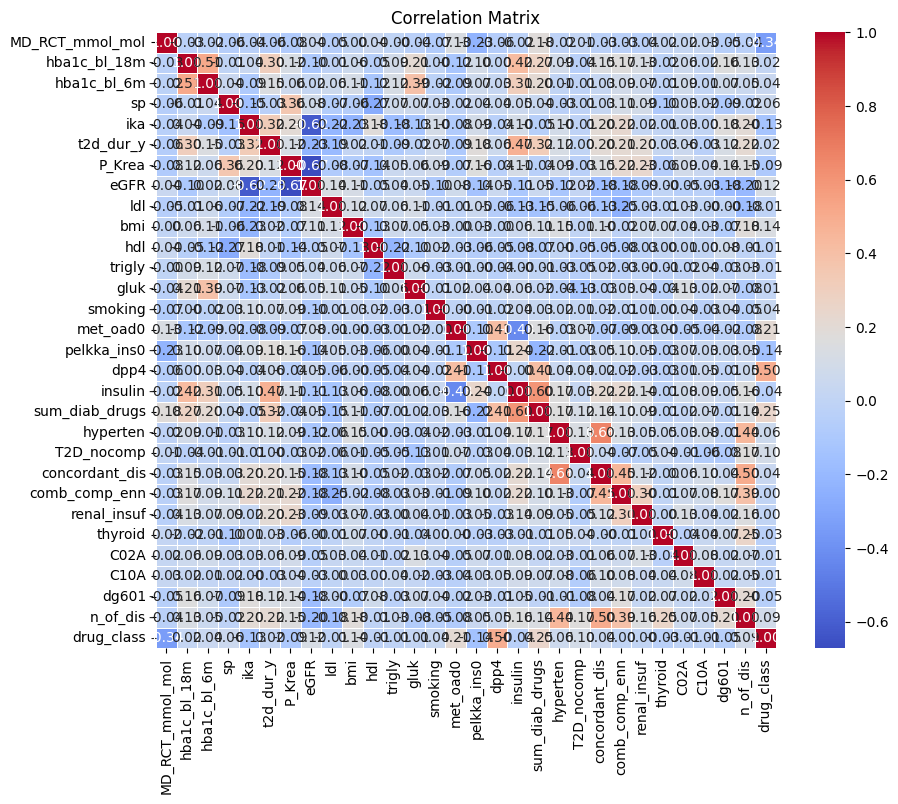

In [13]:
correlation_matrix =pd.DataFrame(X_train).corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [14]:
train = X_train.copy()
train[response_variable_list] = Y_train[response_variable_list].copy()



# Models

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import numpy as np
import random

# Assuming X_train, Y_train, X_test, and Y_test are your training and test data

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32)

# Set seed for reproducibility
seed = 123
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

def calculate_r_squared(y_true, y_pred):
    return r2_score(y_true, y_pred)

# Define your model, optimizer, and loss function
class MultiOutputModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiOutputModel, self).__init__()
        self.fc = nn.Sequential( # 32, 32 or 64,32
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# assuming X_train is a DataFrame
model = MultiOutputModel(number_of_features, 4)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()

# Set hyperparameters
batch_size = 64
epochs = 1000
print_interval = 1000

# Define the dataset class
class Data(Dataset):
    def __init__(self, X, Y):
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len

# Create dataset object
data_set = Data(X_tensor, Y_tensor)

# Create KFold cross-validator
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

# Train the model using cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_tensor)):
    print(f"Training Fold {fold + 1}")

    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_tensor[train_index], X_tensor[val_index]
    Y_train_fold, Y_val_fold = Y_tensor[train_index], Y_tensor[val_index]

    # Create dataset and dataloaders for training and validation
    train_dataset = Data(X_train_fold, Y_train_fold)
    val_dataset = Data(X_val_fold, Y_val_fold)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    # Train the model
    model.train()
    for epoch in range(epochs):
        for x, y in train_loader:
            y_pred = model(x)
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % print_interval == 0:
            print(f"Fold {fold + 1}, Epoch {epoch}/{epochs}, Loss: {loss.item()}")

    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    # Evaluate on the validation set
    model.eval()
    with torch.no_grad():
        val_losses = []
        for x_val, y_val in val_loader:
            y_pred_val = model(x_val)
            val_loss = criterion(y_pred_val, y_val)
            val_losses.append(val_loss.item())

        avg_val_loss = np.mean(val_losses)
        print(f"Fold {fold + 1}, Average Validation Loss: {avg_val_loss}")

        
        
# Create dataset and dataloader for the entire training dataset
full_train_dataset = Data(X_tensor, Y_tensor)
full_train_loader = DataLoader(dataset=full_train_dataset, batch_size=batch_size, shuffle=True)
losses = []
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
# Reset the model to training mode
model.train()

# Additional training on the full training dataset
for epoch in range(epochs):
    for x, y in full_train_loader:
        y_pred = model(x)
        loss = criterion(y_pred, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % print_interval == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

print("Done training on the entire dataset!")

# Test the model on the test data
test_dataset = Data(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=Y_test.shape[0], shuffle=False)

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
model.eval()
with torch.no_grad():
    for x_test, y_test in test_loader:
        y_pred_test = model(x_test)

y_test_numpy = y_test.numpy()
y_pred_test_numpy = y_pred_test.numpy()

# Calculate R-squared on test data
r_squared = calculate_r_squared(y_test_numpy, y_pred_test_numpy)
print(f"R-squared on test data: {r_squared}")
rmse = np.sqrt(mean_squared_error(y_test_numpy, y_pred_test_numpy))
print(f"RMSE (Target): {rmse}")


Training Fold 1
Fold 1, Epoch 0/1000, Loss: 924.1503295898438
Fold 1, Average Validation Loss: 32.313742773873464
Training Fold 2
Fold 2, Epoch 0/1000, Loss: 5.634012699127197
Fold 2, Average Validation Loss: 25.393541881016322
Training Fold 3
Fold 3, Epoch 0/1000, Loss: 18.724348068237305
Fold 3, Average Validation Loss: 16.493743079049246
Epoch 0/1000, Loss: 13.002408027648926
Done training on the entire dataset!
R-squared on test data: 0.30080848475779765
RMSE (Target): 5.4120941162109375


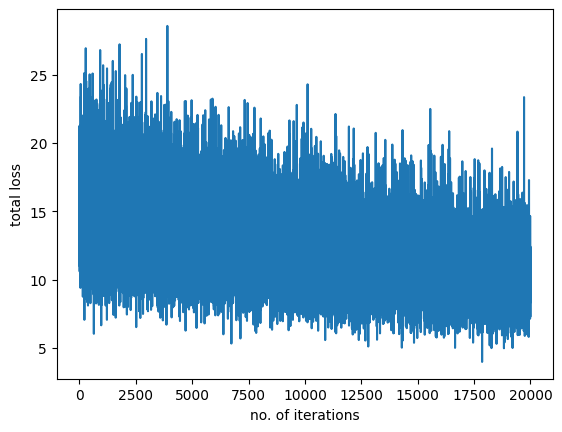

In [16]:
plt.plot(losses)
plt.xlabel("no. of iterations")
plt.ylabel("total loss")
plt.show()

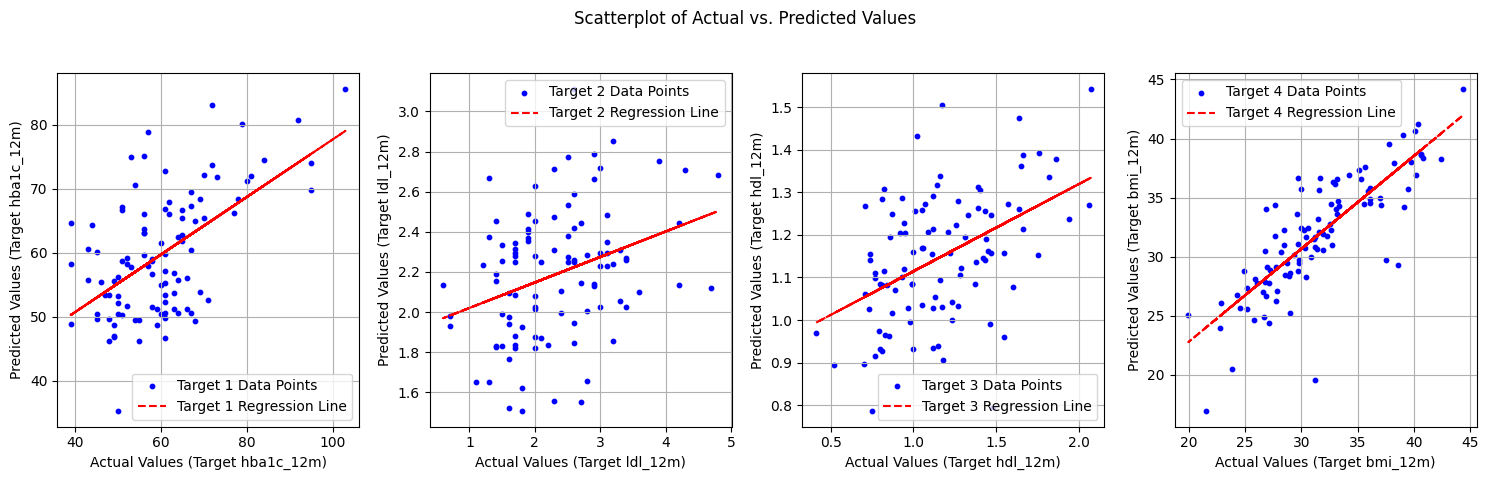

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming Y_test and y_pred are your true and predicted values for multiple features
# Replace Y_test and y_pred with your actual variables

# Number of target features
num_targets = Y_test.shape[1]
names = Y_test.columns.tolist()
# Create subplots for each target feature
fig, axes = plt.subplots(nrows=1, ncols=num_targets, figsize=(15, 5))

# Set a common title
fig.suptitle('Scatterplot of Actual vs. Predicted Values')
y_pred = y_pred_test_numpy

# Plot each target feature separately
for i, val in enumerate(names):
    ax = axes[i] if num_targets > 1 else axes  # Handle the case when there's only one target
    
    ax.scatter(Y_test.iloc[:, i], y_pred[:, i], c='blue', marker='o', s=10, label=f'Target {i + 1} Data Points')
    ax.plot(Y_test.iloc[:, i], np.poly1d(np.polyfit(Y_test.iloc[:, i], y_pred[:, i], 1))(Y_test.iloc[:, i]), color='red', linestyle='--', label=f'Target {i + 1} Regression Line')
    
    ax.set_xlabel(f'Actual Values (Target {val})')
    ax.set_ylabel(f'Predicted Values (Target {val})')
    ax.legend()
    ax.grid(True)

# Adjust layout for better appearance
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure with higher resolution
# plt.savefig('resources/img/MultiOutput_Scatterplot.png', dpi=300, bbox_inches='tight')

plt.show()


In [18]:
# make copies of test dataset
# drug classes after normalization
# 0 = GLP-1 - 2
# 0.5 = DPP-4 -3
# 1 = SGLT2 - 4

if(is_train_with_all):
    sglt_val = 0.375
    dpp_val = 0.25
else:
    sglt_val = 1
    dpp_val = 0

X = X_test.copy()
X_test_copy = X_test.copy()
X_test_copy['assigned_drug_hba1c'] = np.nan
X_test_copy['predicted_change_hba1c'] = np.nan
X_test_copy['assigned_drug_ldl'] = np.nan
X_test_copy['predicted_change_ldl'] = np.nan
X_test_copy['assigned_drug_hdl'] = np.nan
X_test_copy['predicted_change_hdl'] = np.nan
X_test_copy['assigned_drug_bmi'] = np.nan
X_test_copy['predicted_change_bmi'] = np.nan

    
def pred_all(model, row, drug_class):
    if drug_class == sglt_val:
        pred_sglt_ = model(torch.tensor(row.values[None], dtype=torch.float32))[0]
        row['drug_class'] = dpp_val
        pred_dpp_ = model(torch.tensor(row.values[None], dtype=torch.float32))[0]
        
    elif drug_class == dpp_val:
        pred_dpp_ = model(torch.tensor(row.values[None], dtype=torch.float32))[0]
        row['drug_class'] = sglt_val
        pred_sglt_ = model(torch.tensor(row.values[None], dtype=torch.float32))[0]
    else:
        print('Worng drug class')
    return pred_sglt_, pred_dpp_


assigned_drug_class_0 = np.nan
assigned_drug_class_1 = np.nan
assigned_drug_class_2 = np.nan
assigned_drug_class_3 = np.nan
max_change_0 = np.nan
max_change_1 = np.nan
max_change_2 = np.nan
max_change_3 = np.nan
    
for index, row in X.iterrows():
    drug_class = row['drug_class']    
    pred_original = model(torch.tensor(row.values[None], dtype=torch.float32))[0]
    
    pred_sglt, pred_dpp = pred_all(model, row, drug_class) 
    for j in range(Y_train.shape[1]):
        variable_change_name = f"max_change_{j}"
        variable_drug_name = f"assigned_drug_class_{j}"
        
        if (Y_train.iloc[:,j].name == 'hdl_12m'):
            temp_max_change, temp_assigned_drug_class = find_highest_respponse_value(pred_sglt[j], pred_dpp[j])
        else:
            temp_max_change, temp_assigned_drug_class = find_lowest_respponse_value(pred_sglt[j], pred_dpp[j])
            
        # Update the original variables
        globals()[variable_change_name] = temp_max_change
        globals()[variable_drug_name] = temp_assigned_drug_class        
    
#     print('actual: ', drug_class, 'assigned: ', assigned_drug_class_0)
    X_test_copy.at[index, 'assigned_drug_hba1c'] = assigned_drug_class_0
    X_test_copy.at[index, 'predicted_change_hba1c'] = max_change_0.item()
    
    X_test_copy.at[index, 'assigned_drug_ldl'] = assigned_drug_class_1
    X_test_copy.at[index, 'predicted_change_ldl'] = max_change_1.item()
    
    X_test_copy.at[index, 'assigned_drug_hdl'] = assigned_drug_class_2
    X_test_copy.at[index, 'predicted_change_hdl'] = max_change_2.item()
    
    X_test_copy.at[index, 'assigned_drug_bmi'] = assigned_drug_class_3
    X_test_copy.at[index, 'predicted_change_bmi'] = max_change_3.item()


denormalized_test_data = scaler.inverse_transform(X_test_original)
denormalized_test_df = pd.DataFrame(denormalized_test_data, columns=X_test_original.columns)
denormalized_test_df = denormalized_test_df.drop(['drug_class'], axis = 1)

data = denormalized_test_df
X_test_ = X_test_copy.copy()
X_test_= X_test_.reset_index()
Y_test = pd.DataFrame(Y_test)
Y_test = Y_test.reset_index()

data[response_variable_list] = Y_test[response_variable_list]

data['assigned_drug_hba1c'] = X_test_['assigned_drug_hba1c']
data['predicted_change_hba1c'] = X_test_['predicted_change_hba1c']
data['assigned_drug_ldl'] = X_test_['assigned_drug_ldl']
data['predicted_change_ldl'] = X_test_['predicted_change_ldl']
data['assigned_drug_hdl'] = X_test_['assigned_drug_hdl']
data['predicted_change_hdl'] = X_test_['predicted_change_hdl']
data['assigned_drug_bmi'] = X_test_['assigned_drug_bmi']
data['predicted_change_bmi'] = X_test_['predicted_change_bmi']
data['drug_class'] = X_test_['drug_class']


# drug classes after normalization
# 0 = GLP-1 
# 0.5 = DPP-4 
# 1 = SGLT2

# 2=GLP-1 analogues (A10BJ)
# 3=DPP-4 inhibitors (A10BH)
# 4=SGLT2 inhibitors (A10BK)

dpp_strata_hba1c = data[(data['assigned_drug_hba1c'] == dpp_val)]
sglt_strata_hba1c = data[(data['assigned_drug_hba1c'] == sglt_val)] 

dpp_strata_ldl = data[(data['assigned_drug_ldl'] == dpp_val)]
sglt_strata_ldl = data[(data['assigned_drug_ldl'] == sglt_val)] 

dpp_strata_hdl = data[(data['assigned_drug_hdl'] == dpp_val)]
sglt_strata_hdl = data[(data['assigned_drug_hdl'] == sglt_val)] 

dpp_strata_bmi = data[(data['assigned_drug_bmi'] == dpp_val)]
sglt_strata_bmi = data[(data['assigned_drug_bmi'] == sglt_val)] 

dpp_strata_actual = data[(data['drug_class'] == dpp_val)]
sglt_strata_actual = data[(data['drug_class'] == sglt_val)] 


In [19]:
print(' Sample count in test data')
print(' number of dpp4 samples in test dataset : ', dpp_strata_actual.shape[0])
print(' number of sglt2 samples in test dataset : ', sglt_strata_actual.shape[0])

print(' \n Assigned sample count: HBA1C')

print(' number of dpp4 assigned : ', dpp_strata_hba1c.shape[0])
print(' number of sglt2 assigned : ', sglt_strata_hba1c.shape[0])

print(' \n Assigned sample count: LDL')

print(' number of dpp4 assigned : ', dpp_strata_ldl.shape[0])
print(' number of sglt2 assigned : ', sglt_strata_ldl.shape[0])

print(' \n Assigned sample count: HDL')

print(' number of dpp4 assigned : ', dpp_strata_hdl.shape[0])
print(' number of sglt2 assigned : ', sglt_strata_hdl.shape[0])

print(' \n Assigned sample count: BMI')

print(' number of dpp4 assigned : ', dpp_strata_bmi.shape[0])
print(' number of sglt2 assigned : ', sglt_strata_bmi.shape[0])



 Sample count in test data
 number of dpp4 samples in test dataset :  49
 number of sglt2 samples in test dataset :  52
 
 Assigned sample count: HBA1C
 number of dpp4 assigned :  50
 number of sglt2 assigned :  51
 
 Assigned sample count: LDL
 number of dpp4 assigned :  39
 number of sglt2 assigned :  62
 
 Assigned sample count: HDL
 number of dpp4 assigned :  29
 number of sglt2 assigned :  72
 
 Assigned sample count: BMI
 number of dpp4 assigned :  49
 number of sglt2 assigned :  52


In [20]:
# glp_strata - check concordant and discordant
# 0 = GLP-1 
# 0.5 = DPP-4 
# 1 = SGLT2
    
print('HBA1C')
(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
    concordant_sglt_hba1c, discordant_sglt_dpp_hba1c ) = get_concordant_discordant(dpp_strata_hba1c,sglt_strata_hba1c, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                               variable_name = 'assigned_drug_hba1c')
print('LDL')
(concordant_dpp_ldl, discordant_dpp_sglt_ldl,
    concordant_sglt_ldl, discordant_sglt_dpp_ldl ) = get_concordant_discordant(dpp_strata_ldl,sglt_strata_ldl, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                               variable_name = 'assigned_drug_ldl')
print('HDL')
(concordant_dpp_hdl, discordant_dpp_sglt_hdl,
    concordant_sglt_hdl, discordant_sglt_dpp_hdl ) = get_concordant_discordant(dpp_strata_hdl,sglt_strata_hdl, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                                 variable_name = 'assigned_drug_hdl')
print('BMI') 
(concordant_dpp_bmi, discordant_dpp_sglt_bmi,
    concordant_sglt_bmi, discordant_sglt_dpp_bmi ) = get_concordant_discordant(dpp_strata_bmi,sglt_strata_bmi, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                                  variable_name = 'assigned_drug_bmi')

    


HBA1C
 =========== Total number of samples assigned by the model VS Total number of samples in original test data
DPP samples  50 49
SGLT samples  51 52


Category    Real value    Predicted value    Count    Percentage of Predicted cases
----------  ------------  -----------------  -------  -------------------------------
Concordant  SGLT          SGLT               30       58.82%
Discordant  DPP           SGLT               21       44.00%

Concordant  DPP           DPP                28       56.00%
Discordant  SGLT          DPP                22       41.18%


LDL
 =========== Total number of samples assigned by the model VS Total number of samples in original test data
DPP samples  39 49
SGLT samples  62 52


Category    Real value    Predicted value    Count    Percentage of Predicted cases
----------  ------------  -----------------  -------  -------------------------------
Concordant  SGLT          SGLT               35       56.45%
Discordant  DPP           SGLT              

In [21]:


print('\n============= HBA1C ===================')    
print_change_mean(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
            concordant_sglt_hba1c, discordant_sglt_dpp_hba1c, response_variable = 'hba1c_12m')

print('\n\n====== Percentage =========')
calculate_percentage_change(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
            concordant_sglt_hba1c, discordant_sglt_dpp_hba1c, response_variable = 'hba1c_12m', baseline_val='hba1c_bl_6m')

print('\n\n====== Percentage in Original data =========')
percentage_change_original_data(dpp_strata_actual, sglt_strata_actual,baseline_val='hba1c_bl_6m', response_variable = 'hba1c_12m')



============= HBA1C ===================
-------- Average Change --------
Category    Real value    Predicted value    Average
----------  ------------  -----------------  -----------------
Concordant  SGLT          SGLT               59.63333333333333
Discordant  DPP           SGLT               66.76190476190476

Concordant  DPP           DPP                57.57142857142857
Discordant  SGLT          DPP                57.59090909090909




====== Percentage =========
Category    Real value    Predicted value    Mean % Change from Baseline    std     treatment difference
----------  ------------  -----------------  -----------------------------  ------  ----------------------
Concordant  SGLT          SGLT               -10.57%                        14.50%  -7.71%
Discordant  DPP           SGLT               -2.86%                         11.62%

Concordant  DPP           DPP                -5.04%                         15.10%  2.87
Discordant  SGLT          DPP                -7.9

In [22]:

print('\n============= LDL ===================')    
print_change_mean(concordant_dpp_ldl, discordant_dpp_sglt_ldl,
            concordant_sglt_ldl, discordant_sglt_dpp_ldl,response_variable = 'ldl_12m')

print('\n\n====== Percentage =========')
calculate_percentage_change(concordant_dpp_ldl, discordant_dpp_sglt_ldl,
            concordant_sglt_ldl, discordant_sglt_dpp_ldl, response_variable = 'ldl_12m', baseline_val='ldl')

print('\n\n====== Percentage in Original data =========')
percentage_change_original_data(dpp_strata_actual, sglt_strata_actual, baseline_val='ldl', response_variable = 'ldl_12m')



============= LDL ===================
-------- Average Change --------
Category    Real value    Predicted value    Average
----------  ------------  -----------------  ------------------
Concordant  SGLT          SGLT               2.520000001362392
Discordant  DPP           SGLT               2.5148147962711476

Concordant  DPP           DPP                2.0863636352799158
Discordant  SGLT          DPP                1.947058817919563




====== Percentage =========
Category    Real value    Predicted value    Mean % Change from Baseline    std    treatment difference
----------  ------------  -----------------  -----------------------------  -----  ----------------------
Concordant  SGLT          SGLT               -0.36%                         0.98%  -0.29%
Discordant  DPP           SGLT               -0.07%                         0.80%

Concordant  DPP           DPP                -0.27%                         0.73%  -0.17
Discordant  SGLT          DPP                -0.10% 

In [23]:

print('\n============= HDL ===================')    
print_change_mean(concordant_dpp_hdl, discordant_dpp_sglt_hdl,
            concordant_sglt_hdl, discordant_sglt_dpp_hdl, response_variable = 'hdl_12m')

print('\n\n====== Percentage =========')
calculate_percentage_change(concordant_dpp_hdl, discordant_dpp_sglt_hdl,
            concordant_sglt_hdl, discordant_sglt_dpp_hdl, response_variable = 'hdl_12m', baseline_val='hdl')

print('\n\n====== Percentage in Original data =========')
percentage_change_original_data(dpp_strata_actual, sglt_strata_actual, baseline_val='hdl', response_variable = 'hdl_12m')



============= HDL ===================
-------- Average Change --------
Category    Real value    Predicted value    Average
----------  ------------  -----------------  ------------------
Concordant  SGLT          SGLT               1.09222222202354
Discordant  DPP           SGLT               1.2055555548932817

Concordant  DPP           DPP                1.0738461453181047
Discordant  SGLT          DPP                1.2849999777972698




====== Percentage =========
Category    Real value    Predicted value    Mean % Change from Baseline    std    treatment difference
----------  ------------  -----------------  -----------------------------  -----  ----------------------
Concordant  SGLT          SGLT               -0.00%                         0.25%  -0.02%
Discordant  DPP           SGLT               0.02%                          0.26%

Concordant  DPP           DPP                -0.05%                         0.28%  -0.08
Discordant  SGLT          DPP                0.03%  

In [24]:

print('\n============= BMI ===================')    
print_change_mean(concordant_dpp_bmi, discordant_dpp_sglt_bmi,
            concordant_sglt_bmi, discordant_sglt_dpp_bmi, response_variable = 'bmi_12m')

print('\n\n====== Percentage =========')
calculate_percentage_change(concordant_dpp_bmi, discordant_dpp_sglt_bmi,
            concordant_sglt_bmi, discordant_sglt_dpp_bmi, response_variable = 'bmi_12m', baseline_val='bmi')

print('\n\n====== Percentage in Original data =========')
percentage_change_original_data(dpp_strata_actual, sglt_strata_actual,baseline_val='bmi', response_variable = 'bmi_12m')



============= BMI ===================
-------- Average Change --------
Category    Real value    Predicted value    Average
----------  ------------  -----------------  ------------------
Concordant  SGLT          SGLT               31.947541645595006
Discordant  DPP           SGLT               30.362826744715374

Concordant  DPP           DPP                31.78024200439453
Discordant  SGLT          DPP                31.512506087621052




====== Percentage =========
Category    Real value    Predicted value    Mean % Change from Baseline    std    treatment difference
----------  ------------  -----------------  -----------------------------  -----  ----------------------
Concordant  SGLT          SGLT               -1.27%                         2.87%  -1.39%
Discordant  DPP           SGLT               0.12%                          3.06%

Concordant  DPP           DPP                0.31%                          2.44%  1.58
Discordant  SGLT          DPP                -1.27% 

# Remove outliers in our model predicted change

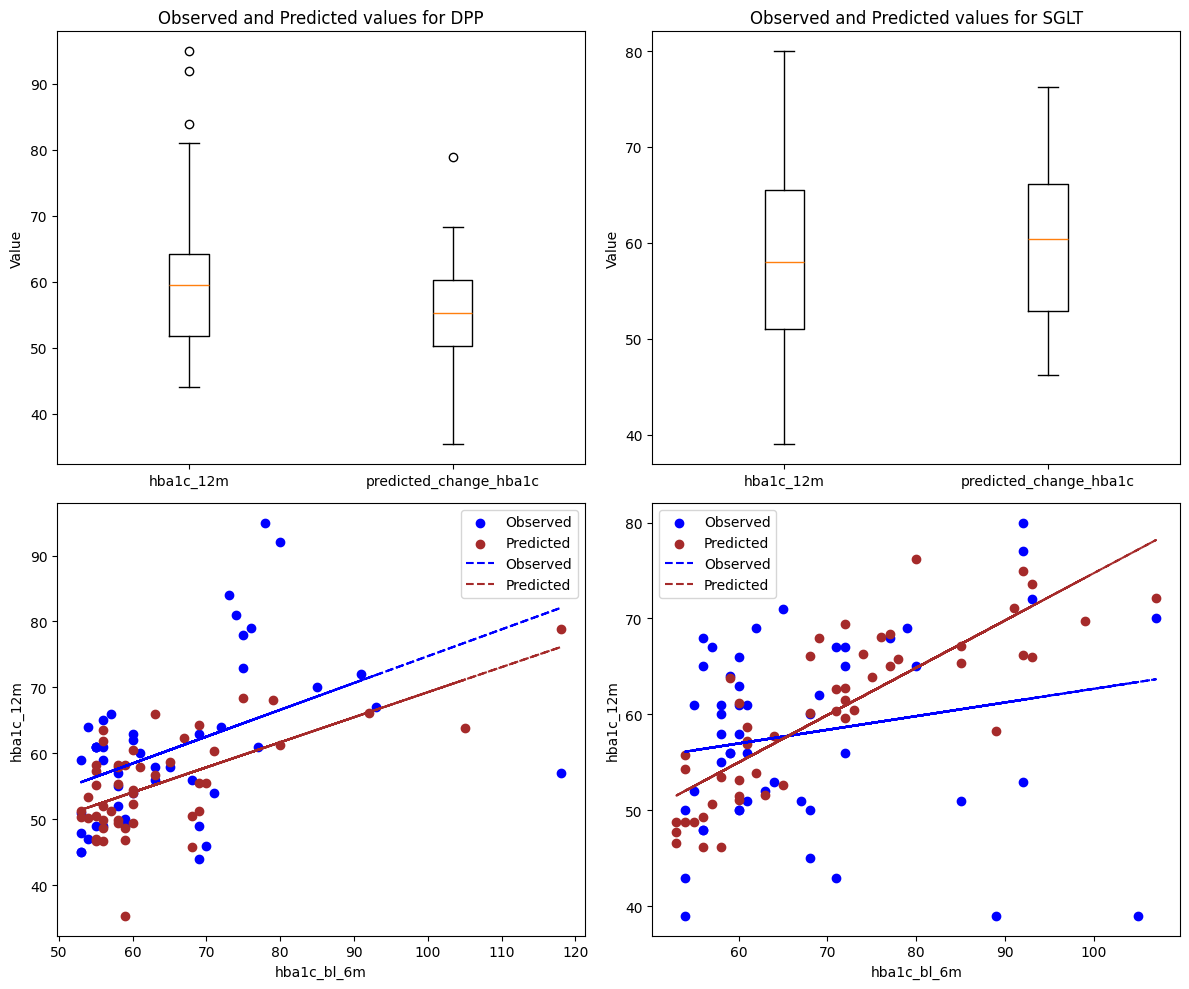

In [25]:


df_ = drug_class_visualization(dpp_strata_hba1c, dpp_strata_actual, sglt_strata_hba1c,sglt_strata_actual,
                                     response_variable='hba1c_12m', 
                                     predicted_change='predicted_change_hba1c',
                                     assigned_drug='assigned_drug_hba1c',
                                     baseline_val='hba1c_bl_6m')



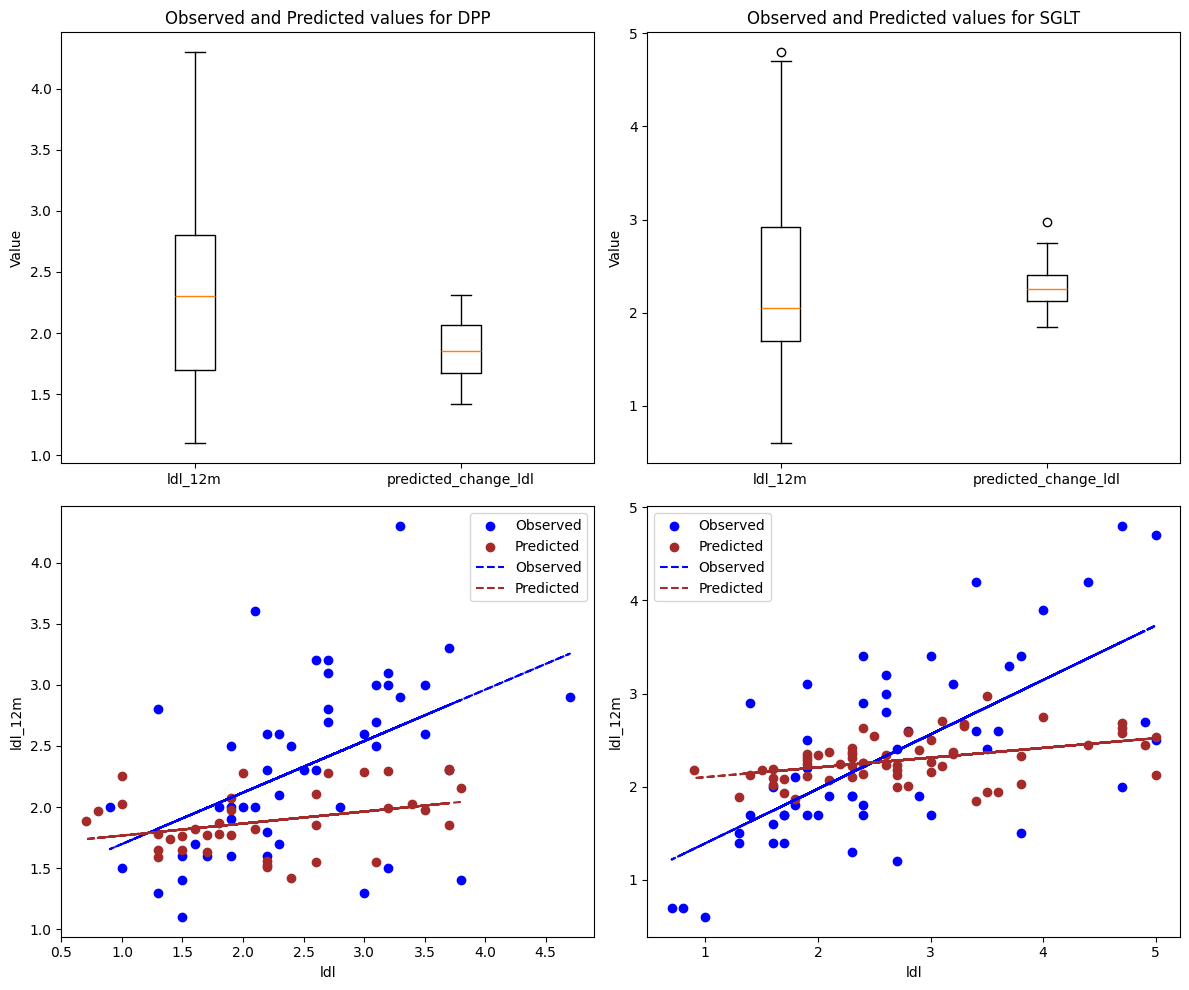

In [26]:
df_ldl_ = drug_class_visualization(dpp_strata_ldl, dpp_strata_actual, sglt_strata_ldl,sglt_strata_actual,
                                     response_variable='ldl_12m', 
                                     predicted_change='predicted_change_ldl',
                                     assigned_drug='assigned_drug_ldl',
                                     baseline_val='ldl')


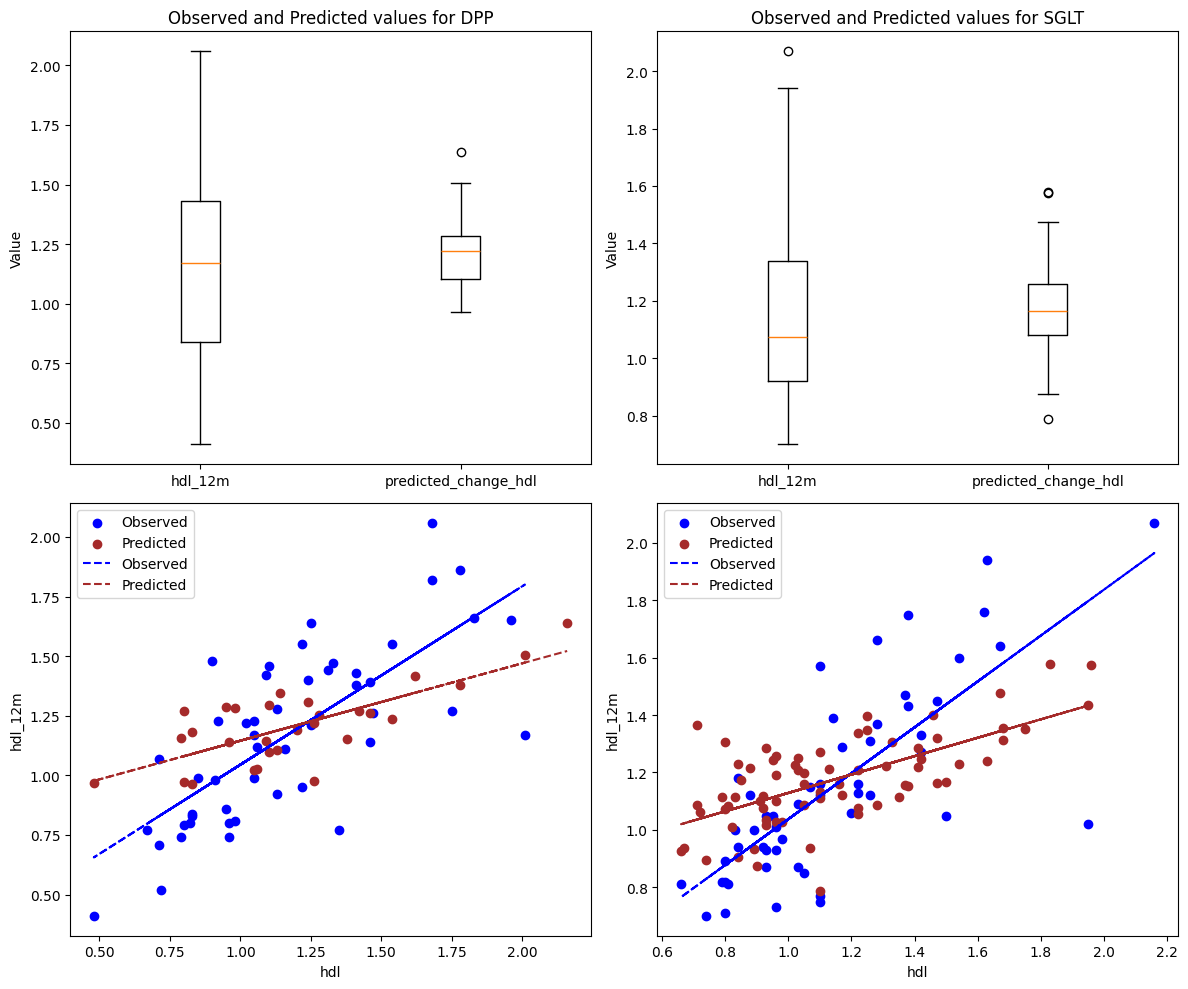

In [27]:
df_hdl_ = drug_class_visualization(dpp_strata_hdl, dpp_strata_actual, sglt_strata_hdl,sglt_strata_actual,
                                     response_variable='hdl_12m', 
                                     predicted_change='predicted_change_hdl',
                                     assigned_drug='assigned_drug_hdl',
                                     baseline_val='hdl')


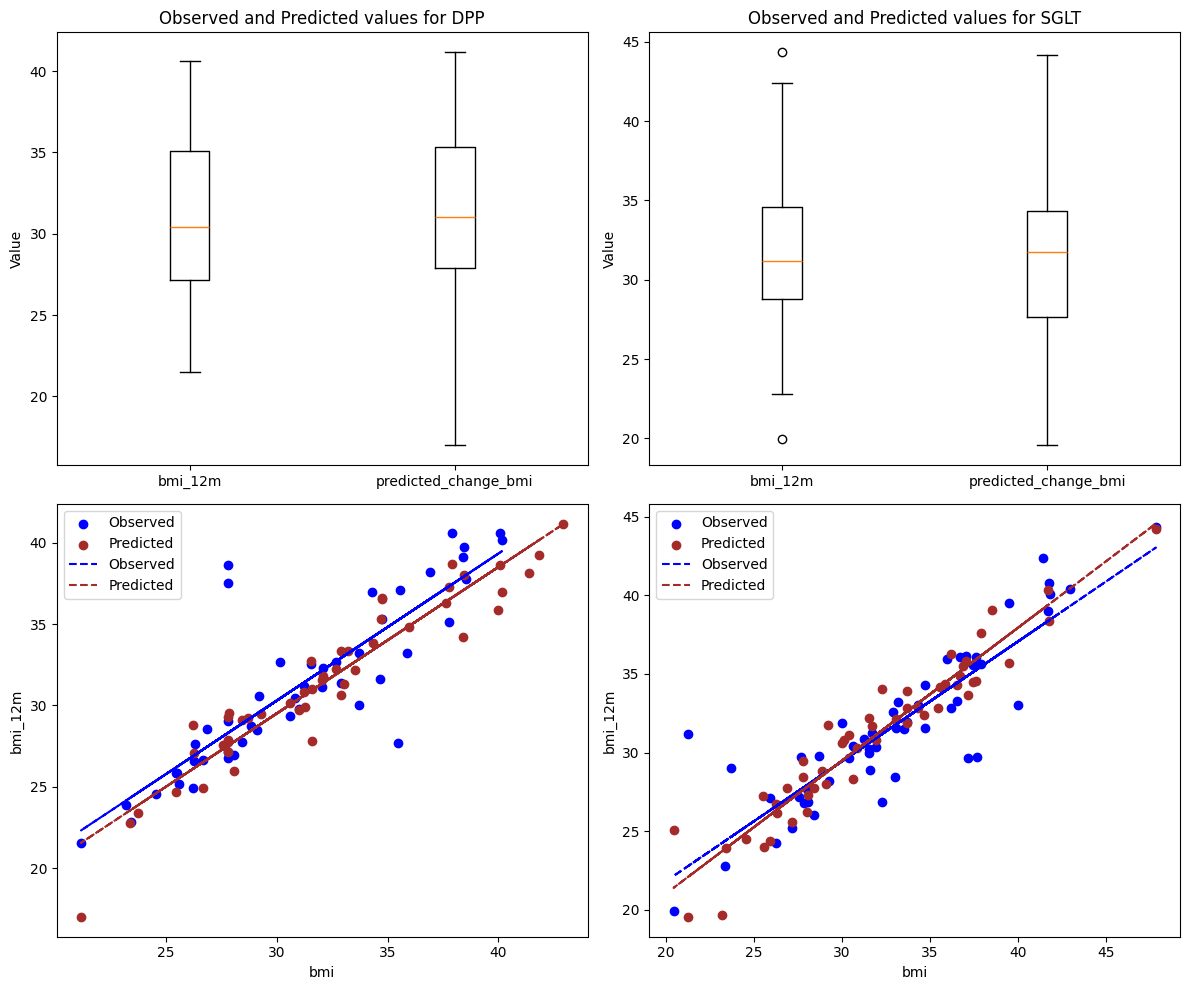

In [28]:
df_bmi_ = drug_class_visualization(dpp_strata_bmi, dpp_strata_actual, sglt_strata_bmi,sglt_strata_actual,
                                     response_variable='bmi_12m', 
                                     predicted_change='predicted_change_bmi',
                                     assigned_drug='assigned_drug_bmi',
                                     baseline_val='bmi')


# SGLT

In [29]:



dpp_df_hba1c = drug_class_outlier_remove(dpp_strata_hba1c, dpp_strata_actual, 'hba1c_12m','predicted_change_hba1c', 'assigned_drug_hba1c', 'hba1c_bl_6m')
sglt_df_hba1c = drug_class_outlier_remove(sglt_strata_hba1c, sglt_strata_actual,'hba1c_12m',
                                            'predicted_change_hba1c', 'assigned_drug_hba1c', 'hba1c_bl_6m')
    
dpp_df_ldl = drug_class_outlier_remove(dpp_strata_ldl, dpp_strata_actual, 'ldl_12m',
                                         'predicted_change_ldl', 'assigned_drug_ldl', 'ldl')
sglt_df_ldl = drug_class_outlier_remove(sglt_strata_ldl, sglt_strata_actual, 'ldl_12m',
                                          'predicted_change_ldl', 'assigned_drug_ldl', 'ldl')
    
dpp_df_hdl = drug_class_outlier_remove(dpp_strata_hdl, dpp_strata_actual, 'hdl_12m',
                                         'predicted_change_hdl', 'assigned_drug_hdl', 'hdl')
sglt_df_hdl = drug_class_outlier_remove(sglt_strata_hdl, sglt_strata_actual, 'hdl_12m',
                                          'predicted_change_hdl', 'assigned_drug_hdl', 'hdl')
    
dpp_df_bmi = drug_class_outlier_remove(dpp_strata_bmi, dpp_strata_actual, 'bmi_12m',
                                         'predicted_change_bmi', 'assigned_drug_bmi', 'bmi')
sglt_df_bmi = drug_class_outlier_remove(sglt_strata_bmi, sglt_strata_actual, 'bmi_12m',
                                          'predicted_change_bmi', 'assigned_drug_bmi', 'bmi')


In [30]:

print('HBA1C')
(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
    concordant_sglt_hba1c, discordant_sglt_dpp_hba1c ) = get_concordant_discordant(dpp_df_hba1c,sglt_df_hba1c, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                                  variable_name = 'assigned_drug_hba1c')

print('\n============= HBA1C ===================')    
print_change_mean(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
            concordant_sglt_hba1c, discordant_sglt_dpp_hba1c, response_variable = 'hba1c_12m')

print('\n\n====== Percentage =========')
calculate_percentage_change(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
            concordant_sglt_hba1c, discordant_sglt_dpp_hba1c, response_variable = 'hba1c_12m', baseline_val='hba1c_bl_6m')

print('\n\n====== Average change of other 3 responses =========')
calculate_percentage_change_othre_responses(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
            concordant_sglt_hba1c, discordant_sglt_dpp_hba1c, 
            response_variable1='ldl_12m', response_variable2='hdl_12m', response_variable3='bmi_12m',
            baseline_val1='ldl',baseline_val2='hdl', baseline_val3='bmi',
            label1='LDL', label2='HDL', label3='BMI')
    
print('\n\n====== Percentage in Original data =========')
percentage_change_original_data(dpp_strata_actual, sglt_strata_actual,baseline_val='hba1c_bl_6m', response_variable = 'hba1c_12m')


calculate_change_diff(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c, concordant_sglt_hba1c, discordant_sglt_dpp_hba1c,
                     'hba1c_12m', 'hba1c_bl_6m', 'predicted_change_hba1c')


HBA1C
 =========== Total number of samples assigned by the model VS Total number of samples in original test data
DPP samples  49 49
SGLT samples  51 52


Category    Real value    Predicted value    Count    Percentage of Predicted cases
----------  ------------  -----------------  -------  -------------------------------
Concordant  SGLT          SGLT               30       58.82%
Discordant  DPP           SGLT               21       44.90%

Concordant  DPP           DPP                27       55.10%
Discordant  SGLT          DPP                22       41.18%



============= HBA1C ===================
-------- Average Change --------
Category    Real value    Predicted value    Average
----------  ------------  -----------------  ------------------
Concordant  SGLT          SGLT               59.63333333333333
Discordant  DPP           SGLT               66.76190476190476

Concordant  DPP           DPP                55.888888888888886
Discordant  SGLT          DPP                5

In [31]:

print('LDL')
(concordant_dpp_ldl, discordant_dpp_sglt_ldl,
    concordant_sglt_ldl, discordant_sglt_dpp_ldl ) = get_concordant_discordant(dpp_df_ldl,sglt_df_ldl, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                                  variable_name = 'assigned_drug_ldl')

print('\n============= LDL ===================')    
print_change_mean(concordant_dpp_ldl, discordant_dpp_sglt_ldl,
            concordant_sglt_ldl, discordant_sglt_dpp_ldl, response_variable = 'ldl_12m')

print('\n\n====== Percentage =========')
calculate_percentage_change(concordant_dpp_ldl, discordant_dpp_sglt_ldl,
            concordant_sglt_ldl, discordant_sglt_dpp_ldl, response_variable = 'ldl_12m', baseline_val='ldl')


print('\n\n====== Average change of other 3 responses =========')
calculate_percentage_change_othre_responses(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
            concordant_sglt_hba1c, discordant_sglt_dpp_hba1c, 
            response_variable1='hba1c_12m', response_variable2='hdl_12m', response_variable3='bmi_12m',
            baseline_val1='hba1c_bl_6m',baseline_val2='hdl', baseline_val3='bmi',
            label1='HBA1C', label2='HDL', label3='BMI')

print('\n\n====== Percentage in Original data =========')
percentage_change_original_data(dpp_strata_actual, sglt_strata_actual, baseline_val='ldl', response_variable = 'ldl_12m')


calculate_change_diff(concordant_dpp_ldl, discordant_dpp_sglt_ldl, concordant_sglt_ldl, discordant_sglt_dpp_ldl,
                     'ldl_12m', 'ldl', 'predicted_change_ldl')


LDL
 =========== Total number of samples assigned by the model VS Total number of samples in original test data
DPP samples  38 49
SGLT samples  62 52


Category    Real value    Predicted value    Count    Percentage of Predicted cases
----------  ------------  -----------------  -------  -------------------------------
Concordant  SGLT          SGLT               35       56.45%
Discordant  DPP           SGLT               27       44.74%

Concordant  DPP           DPP                21       55.26%
Discordant  SGLT          DPP                17       43.55%



============= LDL ===================
-------- Average Change --------
Category    Real value    Predicted value    Average
----------  ------------  -----------------  ------------------
Concordant  SGLT          SGLT               2.520000001362392
Discordant  DPP           SGLT               2.5148147962711476

Concordant  DPP           DPP                2.0333333299273537
Discordant  SGLT          DPP                1.94

In [32]:

print('HDL')
(concordant_dpp_hdl, discordant_dpp_sglt_hdl,
    concordant_sglt_hdl, discordant_sglt_dpp_hdl ) = get_concordant_discordant(dpp_df_hdl,sglt_df_hdl, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                                  variable_name = 'assigned_drug_hdl')
print('\n============= HDL ===================')    
print_change_mean(concordant_dpp_hdl, discordant_dpp_sglt_hdl,
            concordant_sglt_hdl, discordant_sglt_dpp_hdl, response_variable = 'hdl_12m')

print('\n\n====== Percentage =========')
calculate_percentage_change(concordant_dpp_hdl, discordant_dpp_sglt_hdl,
            concordant_sglt_hdl, discordant_sglt_dpp_hdl, response_variable = 'hdl_12m', baseline_val='hdl')

print('\n\n====== Average change of other 3 responses =========')
calculate_percentage_change_othre_responses(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
            concordant_sglt_hba1c, discordant_sglt_dpp_hba1c, 
            response_variable1='hba1c_12m', response_variable2='ldl_12m', response_variable3='bmi_12m',
            baseline_val1='hba1c_bl_6m',baseline_val2='ldl', baseline_val3='bmi',
            label1='HBA1C', label2='LDL', label3='BMI')

print('\n\n====== Percentage in Original data =========')
percentage_change_original_data(dpp_strata_actual, sglt_strata_actual, baseline_val='hdl', response_variable = 'hdl_12m')


calculate_change_diff(concordant_dpp_hdl, discordant_dpp_sglt_hdl, concordant_sglt_hdl, discordant_sglt_dpp_hdl,
                     'hdl_12m', 'hdl', 'predicted_change_hdl')


HDL
 =========== Total number of samples assigned by the model VS Total number of samples in original test data
DPP samples  29 49
SGLT samples  72 52


Category    Real value    Predicted value    Count    Percentage of Predicted cases
----------  ------------  -----------------  -------  -------------------------------
Concordant  SGLT          SGLT               36       50.00%
Discordant  DPP           SGLT               36       55.17%

Concordant  DPP           DPP                13       44.83%
Discordant  SGLT          DPP                16       50.00%



============= HDL ===================
-------- Average Change --------
Category    Real value    Predicted value    Average
----------  ------------  -----------------  ------------------
Concordant  SGLT          SGLT               1.09222222202354
Discordant  DPP           SGLT               1.2055555548932817

Concordant  DPP           DPP                1.0738461453181047
Discordant  SGLT          DPP                1.284

In [33]:

print('BMI')
(concordant_dpp_bmi, discordant_dpp_sglt_bmi,
    concordant_sglt_bmi, discordant_sglt_dpp_bmi ) = get_concordant_discordant(dpp_df_bmi,sglt_df_bmi, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                                  variable_name = 'assigned_drug_bmi')

print('\n============= BMI ===================')    
print_change_mean(concordant_dpp_bmi, discordant_dpp_sglt_bmi,
            concordant_sglt_bmi, discordant_sglt_dpp_bmi, response_variable = 'bmi_12m')

print('\n\n====== Percentage =========')
calculate_percentage_change(concordant_dpp_bmi, discordant_dpp_sglt_bmi,
            concordant_sglt_bmi, discordant_sglt_dpp_bmi,  response_variable = 'bmi_12m', baseline_val='bmi' )

print('\n\n====== Average change of other 3 responses =========')
calculate_percentage_change_othre_responses(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
            concordant_sglt_hba1c, discordant_sglt_dpp_hba1c, 
            response_variable1='hba1c_12m', response_variable2='ldl_12m', response_variable3='hdl_12m',
            baseline_val1='hba1c_bl_6m',baseline_val2='ldl', baseline_val3='hdl',
            label1='HBA1C', label2='LDL', label3='HDL')

print('\n\n====== Percentage in Original data =========')
percentage_change_original_data(dpp_strata_actual, sglt_strata_actual,baseline_val='bmi',response_variable = 'bmi_12m')


calculate_change_diff(concordant_dpp_bmi, discordant_dpp_sglt_bmi, concordant_sglt_bmi, discordant_sglt_dpp_bmi,
                     'bmi_12m', 'bmi', 'predicted_change_bmi')


BMI
 =========== Total number of samples assigned by the model VS Total number of samples in original test data
DPP samples  49 49
SGLT samples  52 52


Category    Real value    Predicted value    Count    Percentage of Predicted cases
----------  ------------  -----------------  -------  -------------------------------
Concordant  SGLT          SGLT               28       53.85%
Discordant  DPP           SGLT               24       48.98%

Concordant  DPP           DPP                25       51.02%
Discordant  SGLT          DPP                24       46.15%



============= BMI ===================
-------- Average Change --------
Category    Real value    Predicted value    Average
----------  ------------  -----------------  ------------------
Concordant  SGLT          SGLT               31.947541645595006
Discordant  DPP           SGLT               30.362826744715374

Concordant  DPP           DPP                31.78024200439453
Discordant  SGLT          DPP                31.5

In [34]:
print(f"R-squared on test data: {r_squared}")

R-squared on test data: 0.30080848475779765
